In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tensor_edit import TensorEdit
from simplify_linear import SimplifyLinear
import utils


utils.set_seed(42)

In [2]:
# Fully connected neural network with SimplifyLinear modules
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc = nn.ModuleList()

        for i_l in range(len(hidden_size)+1):
            in_size = 0
            out_size = 0
            if i_l==0:
                in_size = input_size
                out_size = hidden_size[0]
                simplify_row = True
                simplify_col = False
                exclude_from_drain = True
            elif i_l == len(hidden_size):
                in_size = hidden_size[-1]
                out_size = output_size
                simplify_row = False
                simplify_col = True
                exclude_from_drain = False
            else:
                in_size = hidden_size[i_l-1]
                out_size = hidden_size[i_l]
                simplify_row = True
                simplify_col = True
                exclude_from_drain = False

            sl = SimplifyLinear(in_size, out_size, simplify_row, simplify_col, exclude_from_drain)
            self.fc.append(sl)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = x
        for i_l, l in enumerate(self.fc):
            out = self.fc[i_l](out)
            if i_l<len(self.fc)-1:
                out = self.activation(out)
        return out


In [3]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# XOR training data
x = torch.Tensor([[0, 0],[0, 1], [1, 0], [1, 1]])
y = torch.LongTensor([0, 1, 1, 0])

# Define net parameters and model
input_size = 2
hidden_size = [150, 100, 50, 20]
output_size = 2
model = Net(input_size, hidden_size, output_size).to(device)
n_start_params = sum(p.numel() for p in model.parameters())

epochs = 5000
lr = 1e-1
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

plot_every = 25 # epochs
filenames = []


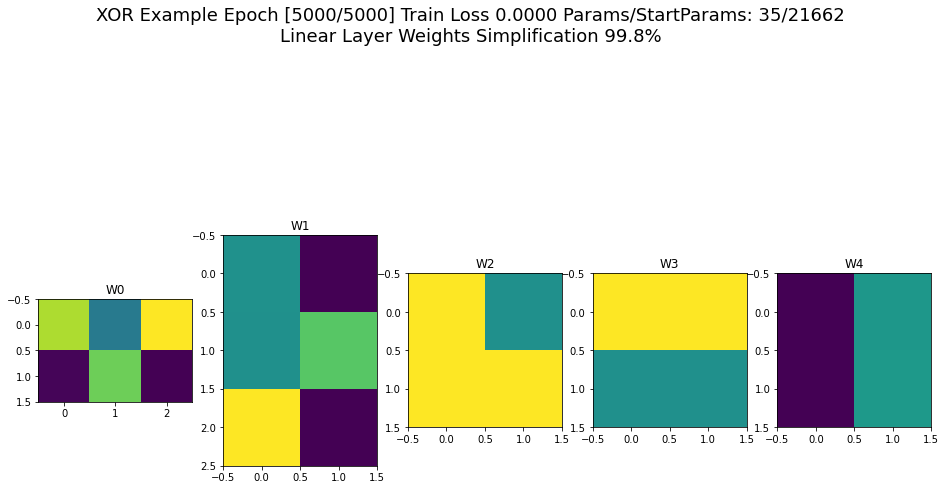

XOR Example Epoch [5000/5000] Train Loss 0.0000 Params/StartParams: 35/21662 Linear Layer Weights Simplification 99.8%


<Figure size 1152x720 with 0 Axes>

In [4]:
%matplotlib inline

# weights figure
fig = plt.figure(figsize=(16, 10), facecolor='white')
# select the layers that can be simplified
simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
te = TensorEdit(simplify_layers)

# train the model
for epoch in range(epochs):
    output = model.forward(x)
    loss = lossFun(output, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    # the force pulling down the weights in the range [-r_value; r_value] to zero
    te.weights_drain(p_drain=0.5, r_value=0.45)
    # the following decay avoids getting stuck in the simplification process.
    te.weights_decay(p_decay=0.5, decay_rate=5e-3)
    # remove weights if all values ​​in a row or column are less than the specified value
    if te.weights_remove(p_remove=1, less_value=0.05, max_removal=0.2, min_size=2, verbose=True):
        # re-instantiate the optimizer with the new model if I have deleted any rows or columns
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)


    if (epoch+1)%plot_every==0:
        # calc the simplification as (1-act_params/start_params)%
        n_params = sum(p.numel() for p in model.parameters())
        simplification = (1 - n_params / n_start_params) * 100

        # select the weight matrices transposing them for a better visualization
        weights = [w.weight.data.T for w in simplify_layers]
        title1 = "XOR Example Epoch [{}/{}] Train Loss {:.4f} Params/StartParams: {}/{}"\
                    .format(epoch+1, epochs, loss.item(), n_params, n_start_params)
        title2 = "Linear Layer Weights Simplification {:.1f}%".format(simplification)
        utils.plot_weights(fig, weights, '\n'.join((title1, title2)))
        print(' '.join((title1, title2)))

        # create a file name, append it to the filenames list
        filename = f'frame_{epoch+1}.png'
        filenames.append(filename)
        # and save the figure
        fig.savefig(filename, facecolor=fig.get_facecolor())
        plt.clf()

In [5]:
# build a gif by composing the frames
utils.images_to_gif(filenames, 'xor_simplify_weights_plot.gif', tail=100)

# create a mjpg video
utils.images_to_avi(filenames, 'xor_simplify_weights_plot.avi')

# Remove frame files
import os
for filename in set(filenames):
    os.remove(filename)